# Convolutional Neural Networks

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
if(len(physical_devices)>0) :
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  0


## Data Preparation

In [3]:
# Organize data into train, valid, test dirs
os.chdir('/Coding/Learning/DL_Learning/Datasets/dogs-vs-cats/')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for c in random.sample(glob.glob('./old_test_data/cat*'), 500):
        shutil.move(c, 'train/cat')
    
    for c in random.sample(glob.glob('./old_test_data/dog*'), 500):
        shutil.move(c, 'train/dog')
    
    for c in random.sample(glob.glob('./old_test_data/cat*'), 100):
        shutil.move(c, 'valid/cat')
    
    for c in random.sample(glob.glob('./old_test_data/dog*'), 100):
        shutil.move(c, 'valid/dog')
    
    for c in random.sample(glob.glob('./old_test_data/cat*'), 50):
        shutil.move(c, 'test/cat')
    
    for c in random.sample(glob.glob('./old_test_data/dog*'), 50):
        shutil.move(c, 'test/dog')

os.chdir('./../../Keras_Learning/')

In [5]:
train_path='/Coding/Learning/DL_Learning/Datasets/dogs-vs-cats/train'
valid_path='/Coding/Learning/DL_Learning/Datasets/dogs-vs-cats/valid'
test_path='/Coding/Learning/DL_Learning/Datasets/dogs-vs-cats/test'

In [6]:
train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)

test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)

Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [7]:
# Verfication of Batch sizes.
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [9]:
# Returns 10 images and there corresponding labels.
# Then it points to another batch of 10.
imgs, labels = next(train_batches)

In [10]:
# This function will plot images in the form of a grid with 1 row and 10 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

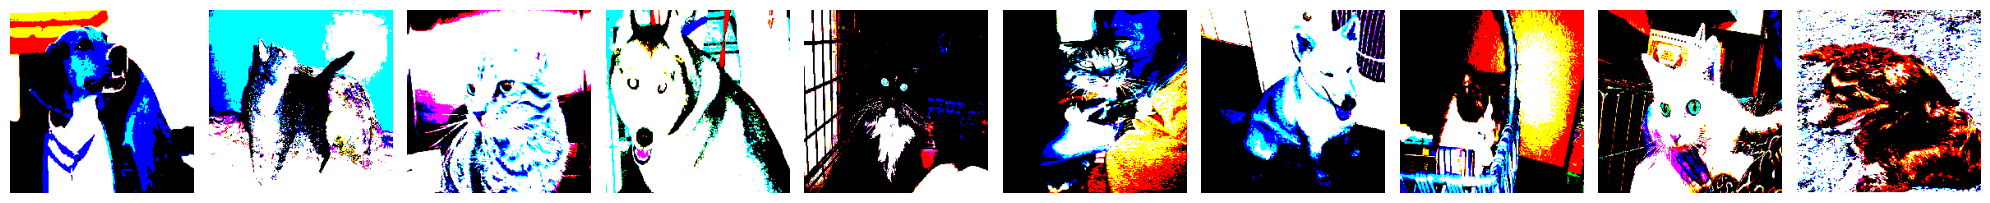

[[0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


In [11]:
plotImages(imgs)
print(labels)

## Build and Train a CNN

In [13]:
model=Sequential([
    # By defining the input_shape we define the very first layer i.e. input layer.
    # The input_shape is the shape of the image that we are going to feed to the model.
    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 200704)            0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [15]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
model.fit(
    x=train_batches,
    validation_data=valid_batches,
    epochs=10,
    verbose=2
)

Epoch 1/10
100/100 - 73s - loss: 16.2203 - accuracy: 0.5700 - val_loss: 8.6525 - val_accuracy: 0.5000 - 73s/epoch - 729ms/step
Epoch 2/10
100/100 - 82s - loss: 2.2101 - accuracy: 0.7710 - val_loss: 3.1288 - val_accuracy: 0.6450 - 82s/epoch - 819ms/step
Epoch 3/10
100/100 - 72s - loss: 0.7611 - accuracy: 0.8630 - val_loss: 3.6902 - val_accuracy: 0.6200 - 72s/epoch - 718ms/step
Epoch 4/10
100/100 - 70s - loss: 0.2050 - accuracy: 0.9470 - val_loss: 2.7912 - val_accuracy: 0.6500 - 70s/epoch - 705ms/step
Epoch 5/10
100/100 - 63s - loss: 0.1728 - accuracy: 0.9600 - val_loss: 3.9399 - val_accuracy: 0.5750 - 63s/epoch - 629ms/step
Epoch 6/10
100/100 - 59s - loss: 0.0541 - accuracy: 0.9860 - val_loss: 2.8831 - val_accuracy: 0.6450 - 59s/epoch - 588ms/step
Epoch 7/10
100/100 - 76s - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.9616 - val_accuracy: 0.6250 - 76s/epoch - 760ms/step
Epoch 8/10
100/100 - 82s - loss: 0.0023 - accuracy: 0.9990 - val_loss: 2.8757 - val_accuracy: 0.6400 - 82s/epoch - 81

## Predict

In [17]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [22]:
predictions=model.predict(x=test_batches, verbose=0)

In [21]:
# Round of predictions
np.round(predictions)

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [23]:
cm=confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks=np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm=cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix without Normalization')

    print(cm)

    thresh=cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j]>thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [24]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion Matrix without Normalization
[[34 16]
 [13 37]]


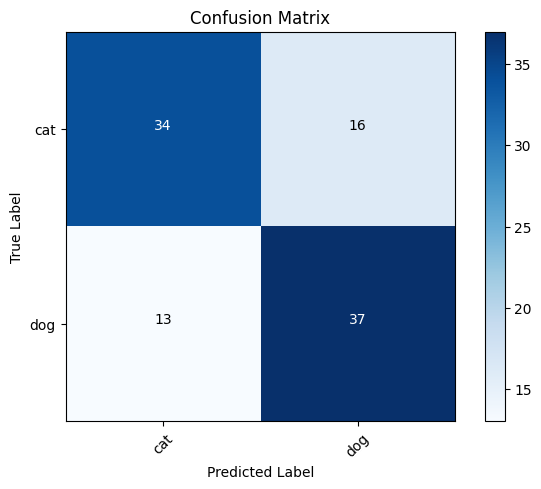

In [25]:
cm_plot_labels=['cat', 'dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')